In [ ]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 50

In [ ]:
# Create function to score results
def scores(data):
  accuracy = (data.TN + data.TP ) / data.iloc[0].sum()
  recall = data.TP / (data.TP + data.FN)
  precision = data.TP / (data.TP + data.FP)
  f1_score = 2*precision*recall / (precision+recall)
  print('Accuracy: ',round(accuracy.values[0],4))
  print('Recall: ',round(recall.values[0],4))
  print('Precision: ',round(precision.values[0],4))
  print('F1 Score: ',round(f1_score.values[0],4))

# Create confusion matrix
def conf_matrix(x_var, y_var):
  y_pred = opt_model.predict(x_var).round()
  cm = confusion_matrix(y_var,y_pred).ravel()
  cm_df = pd.DataFrame(columns=['TN','FP','FN','TP'], data=cm.reshape(1,4))
  print(cm_df)
  print('')
  scores(cm_df)

In [ ]:
# Reload data
df_train = pd.read_csv('Train_set.csv')
df_submit = pd.read_csv('Test_set.csv')

# Concat train and submission set to ensure identical structures
df = pd.concat([df_train,df_submit])
df.columns = df.columns.str.lower()

# Create 2 new features
df['utilization'] = df['revolving_balance'] / df['total_revolving_limit']
df['bal_per_acc'] = df['total_current_balance'] / df['total_acc']

# Select columns for log transformation
num_cols = [item for item in df.select_dtypes(include=['int','float']).columns.to_list() if item not in ['id','default','delinq_2yrs','public_records']]
df[num_cols] = df[num_cols].apply(lambda x: np.log(x+0.001))

# Group states with less than 1000 applications into 1 group
state_list = df.state_code.value_counts()[lambda x: x<1000].index.values
for s in state_list:
  df['state_code'].replace({s:'Other'}, inplace=True)

# More regrouping
df['home_ownership'].replace({'NONE':'RENT','OTHER':'RENT'}, inplace=True)
df['delq_group'] = np.select([df.delinq_2yrs.eq(0), df.delinq_2yrs.eq(1), df.delinq_2yrs.eq(2)],['Never','One','Two'],'>2')
df['public_records_group'] = np.select([df.public_records.eq(0), df.public_records.eq(1)],['Never','One'],'>1')
df.drop(columns=['id','delinq_2yrs','public_records','job_experience','application_type'], inplace=True)

# One-hot encoding
cat_cols = [item for item in df.select_dtypes(include=['object']).columns.to_list()]
df_encoded = pd.get_dummies(df, columns=cat_cols)

# Define train data set
df_train_encoded = df_encoded[df_encoded.default.notnull()]

# Separate dependent from independent variables
x = df_train_encoded.drop(columns='default')
y = df_train_encoded[['default']]

# Split train data set into test and cv
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
x_train_imputed = pd.DataFrame(data=imputer.fit_transform(x_train), columns=x_train.columns)
x_test_imputed = pd.DataFrame(data=imputer.transform(x_test), columns=x_test.columns)

In [ ]:
# Create function to train and optimize model
def optimize_and_fit(X,Y):
    model = RandomForestClassifier(random_state=1, verbose=1)
    param_grid = {
              'n_estimators': np.arange(100,500,50),
              'max_depth': np.arange(5,31,5),
              'min_samples_leaf': np.arange(1,21,3),
              'max_features': [0.5,0.7,0.9],
              'criterion': ['entropy','gini'],
              'class_weight':['balanced_subsample']
              }
    grid_obj = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5, scoring='accuracy')
    grid_obj.fit(X, Y)
    optimized_model = grid_obj.best_estimator_
    optimized_model.fit(X, Y)
    return optimized_model

# Train and optimize model
opt_model = optimize_and_fit(x_train_imputed.values, y_train.values.reshape(y_train.shape[0],))

In [ ]:
conf_matrix(x_train_imputed, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      TN    FP    FN     TP
0  47396  2319  1444  14062

Accuracy:  0.9423
Recall:  0.9069
Precision:  0.8584
F1 Score:  0.882


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.5s finished


In [ ]:
conf_matrix(x_test_imputed, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      TN    FP    FN    TP
0  19409  1921  2487  4136

Accuracy:  0.8423
Recall:  0.6245
Precision:  0.6828
F1 Score:  0.6524


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished


In [ ]:
# Save trained model
joblib.dump(opt_model, 'RFmodel')
opt_model = joblib.load('RFmodel')

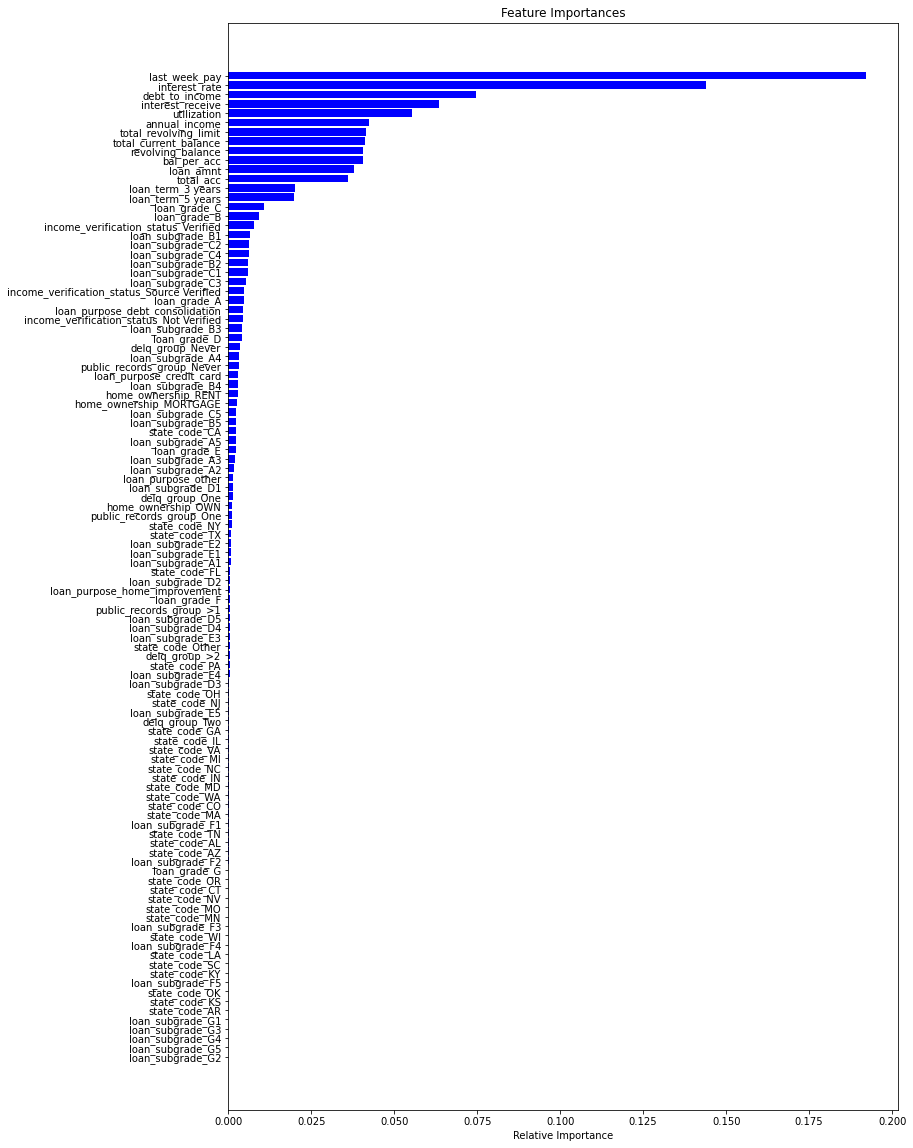

In [ ]:
# Plot features importances
importances = opt_model.feature_importances_
indices = np.argsort(importances)
feature_names = x_train_imputed.columns

plt.figure(figsize=(12,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Error Analysis

In [ ]:
model = joblib.load('RFmodel')
y_pred = model.predict(x_test_imputed)
x_test_imputed['pred'] = np.round(y_pred)
x_test_imputed['actual'] = y_test.values
x_test_imputed['results'] = np.select([x_test_imputed.actual.eq(1)&x_test_imputed.pred.eq(1),
                                       x_test_imputed.actual.eq(1)&x_test_imputed.pred.eq(0),
                                       x_test_imputed.actual.eq(0)&x_test_imputed.pred.eq(0),
                                       x_test_imputed.actual.eq(0)&x_test_imputed.pred.eq(1)],
                                      ['TP','FP','TN','FN'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished


In [ ]:
x_test_imputed.results.value_counts()

TN    19409
TP     4136
FP     2487
FN     1921
Name: results, dtype: int64

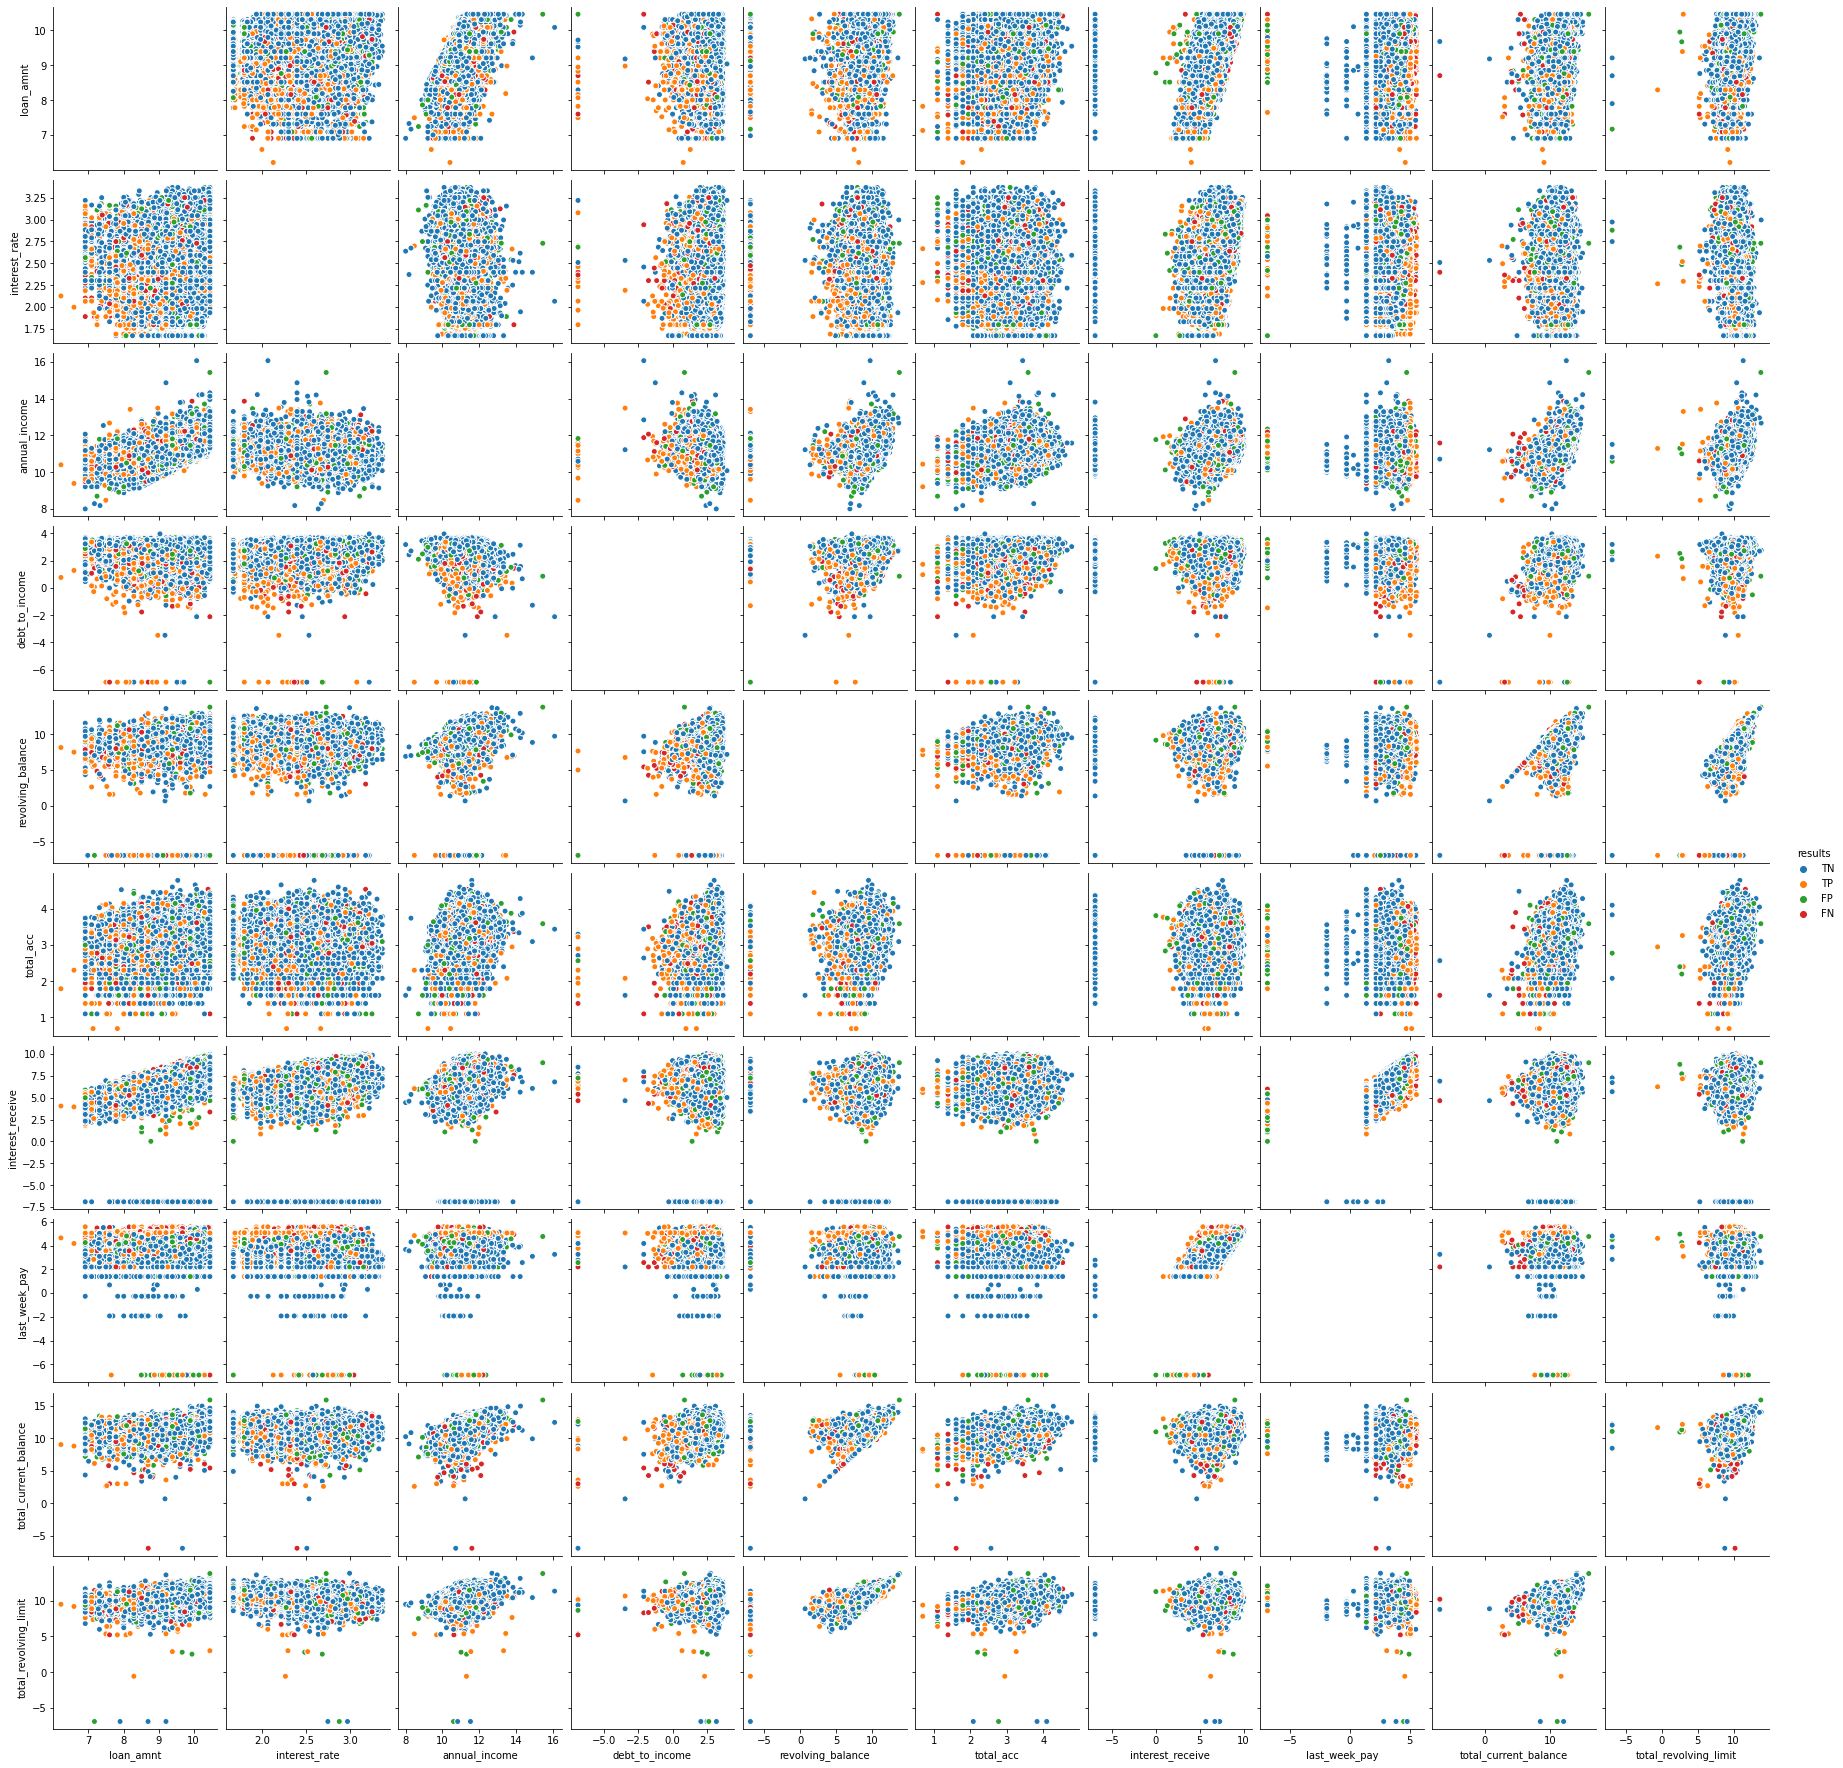

In [ ]:
cols = [item for item in df_train.select_dtypes(include=['int','float']).columns.to_list() if item not in ['ID','delinq_2yrs','public_records','default']]
cols.append('results')
plot_data = x_test_imputed[cols]
sns.pairplot(plot_data, hue='results', kind='scatter', diag_kind='None', corner=False, plot_kws=dict(marker='o',linewidth=1))

In [ ]:
def plot_3d(d1,d2,d3):
  fig = plt.figure(figsize=(20,20))
  ax = fig.add_subplot(111, projection='3d')
  cdict = {'TN':'blue','TP':'green','FN':'red','FP':'orange'}
  for r in plot_data.results.unique():
    ax.scatter(plot_data[d1][plot_data.results.eq(r)], plot_data[d2][plot_data.results.eq(r)], plot_data[d3][plot_data.results.eq(r)], label=r, c=cdict[r],s= 8)
  ax.set_xlabel(d1)
  ax.set_ylabel(d2)
  ax.set_zlabel(d3)
  ax.legend()

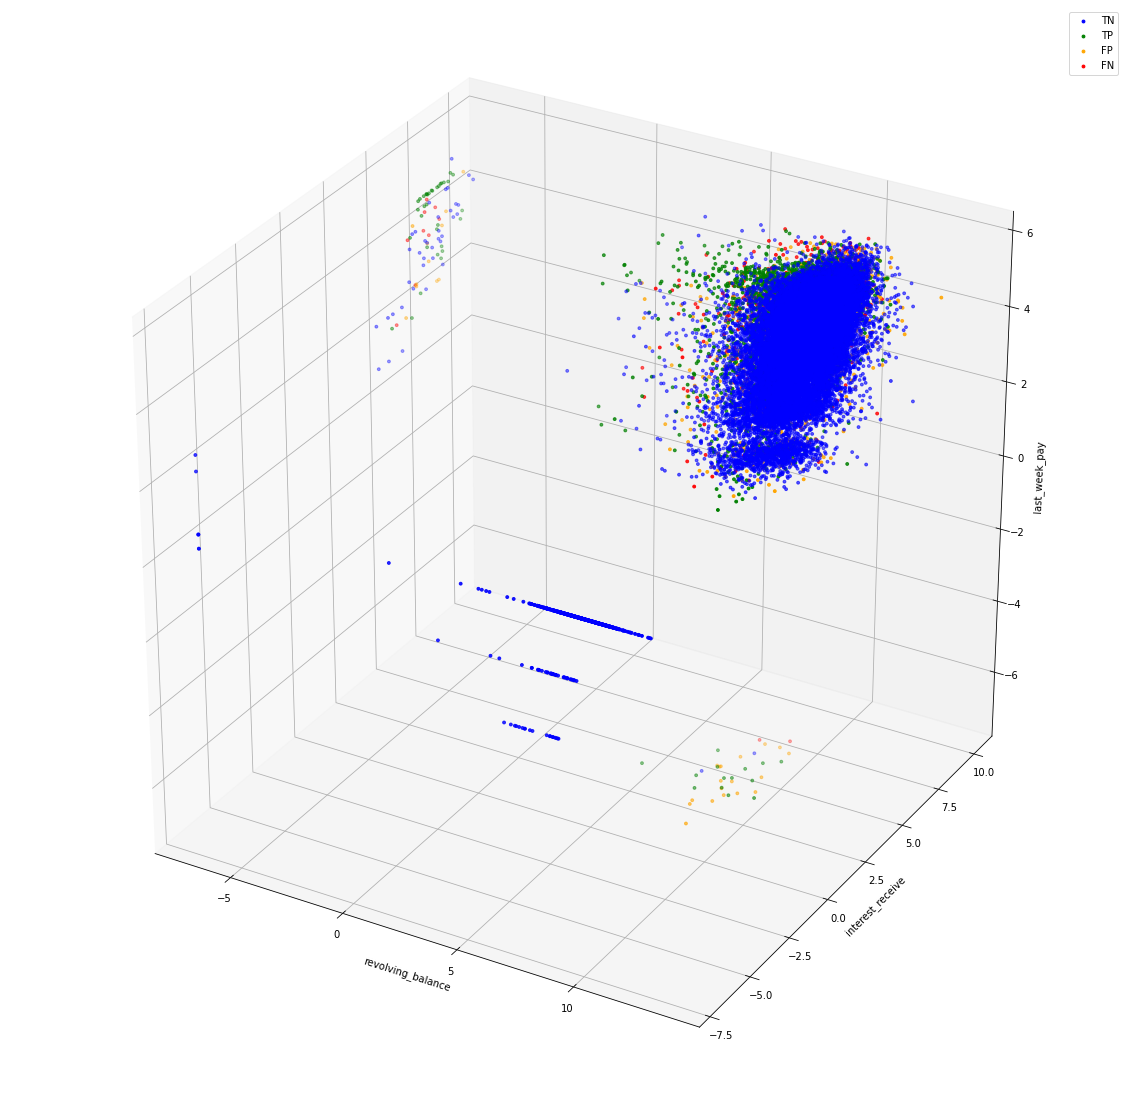

In [ ]:
plot_3d('revolving_balance','interest_receive', 'last_week_pay')

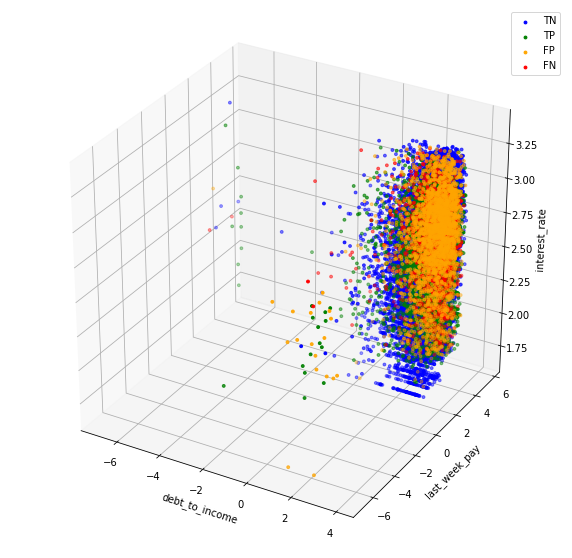

In [ ]:
plot_3d( 'debt_to_income','last_week_pay','interest_rate')